# Wall potential (MD)

## Overview

### Questions

* How do I apply interactions between **wall geometries** and **particles** in molecular dynamics simulations?

### Objectives

* Demonstrate the use of a wall potential class.
    
## Boilerplate code

In [1]:
import os

fn = os.path.join(os.getcwd(), 'initial_state.gsd')
![ -e "$fn" ] && rm "$fn"

The `render` function in the next (hidden) cell will render the system state using **fresnel**. Find the source in the [hoomd-examples](https://github.com/glotzerlab/hoomd-examples) repository.

In [2]:
# This is not intended as a full tutorial on fresnel - see the
# fresnel user documentation (https://fresnel.readthedocs.io/) if you would like to learn more.

import math
import warnings

import fresnel
import IPython
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(snapshot):
    if ('version' not in dir(fresnel) or packaging.version.parse(
            fresnel.version.version) < FRESNEL_MIN_VERSION
            or packaging.version.parse(
                fresnel.version.version) >= FRESNEL_MAX_VERSION):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(scene,
                                       N=len(snapshot.particles.position),
                                       radius=0.5)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear(
        [255 / 255, 154 / 255, 202 / 255]),
                                                  roughness=0.5)
    geometry.position[:] = snapshot.particles.position[:]

    geometry.outline_width = 0.08
    box = fresnel.geometry.Box(scene, [L, L, 0, 0, 0, 0], box_radius=0.08)

    walls = fresnel.geometry.Cylinder(scene, N=4)
    walls.material = fresnel.material.Material(color=fresnel.color.linear(
        [90 / 255, 226 / 255, 75 / 255]),
                                               roughness=0.5)
    walls.outline_width = 0.08

    box_height = 14
    L = snapshot.configuration.box[0]

    walls.points[:] = [
        [[-L / 2, box_height / 2, 0], [L / 2, box_height / 2, 0]],
        [[-L / 2, -box_height / 2, 0], [L / 2, -box_height / 2, 0]],
        [[-box_height / 2, -L / 2, 0], [-box_height / 2, L / 2, 0]],
        [[box_height / 2, -L / 2, 0], [box_height / 2, L / 2, 0]],
    ]
    walls.radius[:] = 0.5

    scene.lights = [
        fresnel.light.Light(direction=(1, 0, 0.4),
                            color=(0.85, 0.85, 0.85),
                            theta=math.pi / 2),
    ]
    scene.camera = fresnel.camera.Orthographic(position=(0, 0, L * 2),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=L + 2)
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

To prepare, place particles in the center of a large simulation box:

In [3]:
import itertools

import gsd.hoomd
import hoomd
import numpy

L = 20
m = 10
N = m**2
x = numpy.linspace(start=-m / 2, stop=m / 2, endpoint=False, num=m) + 1 / 2
position_2d = numpy.array(list(itertools.product(x, repeat=2)))

frame = gsd.hoomd.Frame()
frame.particles.N = N
frame.particles.position = numpy.stack(
    (position_2d[:, 0], position_2d[:, 1], numpy.zeros(N)), axis=-1)
frame.particles.types = ['mobile']
frame.configuration.box = [L, L, 0, 0, 0, 0]

with gsd.hoomd.open(name='initial_state.gsd', mode='x') as f:
    f.append(frame)

Prepare a molecular dynamics simulation:

In [4]:
simulation = hoomd.Simulation(device=hoomd.device.CPU(), seed=1)
simulation.create_state_from_gsd(filename='initial_state.gsd')
langevin = hoomd.md.methods.Langevin(kT=1.0, filter=hoomd.filter.All())
simulation.operations.integrator = hoomd.md.Integrator(dt=0.001,
                                                       methods=[langevin])

## Adding forces between particles and wall geometries

In a molecular dynamics simulation, particles move in response to applied _forces_. Typically, this includes a pair forces between pairs of particles: 

In [5]:
pair_lj = hoomd.md.pair.LJ(nlist=hoomd.md.nlist.Cell(buffer=0.4),
                           default_r_cut=2.5)
pair_lj.params[('mobile', 'mobile')] = dict(epsilon=1, sigma=1)

simulation.operations.integrator.forces.append(pair_lj)

This example gives the pair interaction a range of `r_cut = 2.5`. The simulation box is _always_ periodic. To model an isolated system, place the wall geometries in from the edge of the box so that the particles do not interact across the periodic boundary conditions.

In [6]:
top = hoomd.wall.Plane(origin=(0, 7, 0), normal=(0, -1, 0))
bottom = hoomd.wall.Plane(origin=(0, -7, 0), normal=(0, 1, 0))
left = hoomd.wall.Plane(origin=(-7, 0, 0), normal=(1, 0, 0))
right = hoomd.wall.Plane(origin=(7, 0, 0), normal=(-1, 0, 0))

Apply forces between the particles and the wall geometries using a `hoomd.md.external.wall` force:

In [7]:
wall_lj = hoomd.md.external.wall.LJ(walls=[top, bottom, left, right])

The force due to a wall on a particle follows the form of a pair potential as a function of the distance between the _center_ of the particle and the wall's surface. Set the relevant pair potential parameters:

In [8]:
wall_lj.params['mobile'] = dict(sigma=1.0, epsilon=1.0, r_cut=2.**(1 / 6))

Apply the forces from the walls on the particles:

In [9]:
simulation.operations.integrator.forces.append(wall_lj)

## Run the simulation

In [10]:
simulation.run(50_000)

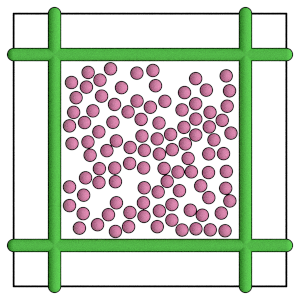

In [11]:
render(simulation.state.get_snapshot())

## Conclusion

This section demonstrates how to apply a force between wall geometries and particles during Molecular Dynamics simulations. The next section shows how to run the same simulation with HPMC.